In [78]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Part 1

In [79]:
sst_wv_ds = xr.open_dataset('hw_data/monthly_mean_sst_tcwv.nc') # SST and total column vapor data
land_sea_mask = xr.open_dataset('hw_data/land_sea_mask.nc') # Land-sea mask

# Grab variables
lsm = land_sea_mask['lsm']
sst = sst_wv_ds['sst']
tcwv = sst_wv_ds['tcwv']

lsm_sea = lsm[0,:,:] == 0 # Mask land areas
sst_sea = sst.where(lsm_sea) # Apply mask to sst data
#tcwv_sea = tcwv.where(lsm_sea) # Apply mask to tcwv data

# Merge dataarrays
combined_sst_tcwv_sea = xr.merge([sst_sea,tcwv])

In [80]:
combined_sst_tcwv_sea

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB nan nan ... nan
    tcwv        (valid_time, latitude, longitude) float32 829MB ...
Attributes: (12/31)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      375641
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

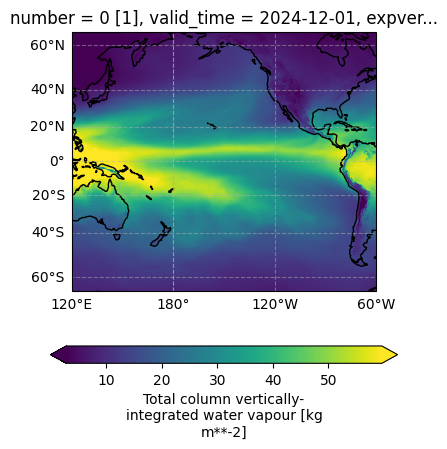

In [81]:
# Plot data to make sure we have correct domain
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Miller(central_longitude=190)))

combined_sst_tcwv_sea['tcwv'].isel(valid_time=551).plot(ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,)

axis.coastlines()

# Add gridlines
gl = axis.gridlines(alpha=0.5, linestyle='--', draw_labels=True)
gl.bottom_labels = True
gl.left_labels = True
gl.top_labels = False
gl.right_labels = False

## Part 2

In [82]:
# De-trending and de-seasonalizing data and getting anomalies

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    (Basically fitting a regression to each point in the time series)

    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


# Example:
# ds is a monthly ERA5 Dataset or DataArray with dimension "time"
# If Dataset, all variables get processed; if DataArray, just that variable
# ds = ds.chunk({"time": -1})  # optional: ensure time is a single chunk for speed
# Optional: keep time in one chunk for speed
ds = combined_sst_tcwv_sea.chunk({"valid_time": -1})

detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time") # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1981-01-01", "2010-12-31")) # or None for full-period

print(type(z), list(z.data_vars))   # Should show a Dataset with ['sst','tcwv']

<class 'xarray.core.dataset.Dataset'> ['sst', 'tcwv']


In [83]:
########## Standardizing sst anomalies #############
# Compute long term mean and std
mean = anom['sst'].mean(dim='valid_time')
std = anom['sst'].std(dim='valid_time')

# Avoid division by zero
std = std.where(std != 0)

# Standardize (subtract mean and divide by std)
sst_standardized = (anom['sst'] - mean) / std

# Check to see if std=1 and mean=0
print(sst_standardized.std().values)
print(sst_standardized.mean().values)

# Store variable back in anom
anom['sst_standardized'] = sst_standardized

anom=anom.compute() # Load data from dask
anom = anom.rename({'valid_time': 'time'}) # Rename time dimension 
                                           # (important for running EOFs)

1.0
3.1680754e-09


In [84]:
anom

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number            (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * time              (time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude          (latitude) float64 4kB 65.0 64.75 64.5 ... -64.75 -65.0
  * longitude         (longitude) float64 6kB 120.0 120.2 120.5 ... 299.8 300.0
    expver            (time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
    month             (time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables:
    sst               (time, latitude, longitude) float32 829MB nan nan ... nan
    tcwv              (time, latitude, longitude) float32 829MB -0.5427 ... 0...
    sst_standardized  (time, latitude, longitude) float32 829MB nan nan ... nan

## Part 3

In [85]:
from eofs.xarray import Eof
from eofs.examples import example_data_path

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
# This is done because grid size changes with latitude
coslat = np.cos(np.deg2rad(anom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(anom['sst_standardized'], weights=wgts)

In [86]:
# Retrieve the first 10 EOFs, expressed as the correlation between the
# time series of the PCs and the input SST anomalies at each grid point.
# Also get the 2 PCs time series itself.
eof1 = solver.eofsAsCorrelation(neofs=10) # 10 EOF patterns
pc1 = solver.pcs(npcs=2, pcscaling=1) # 2 Principal components


/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/global/

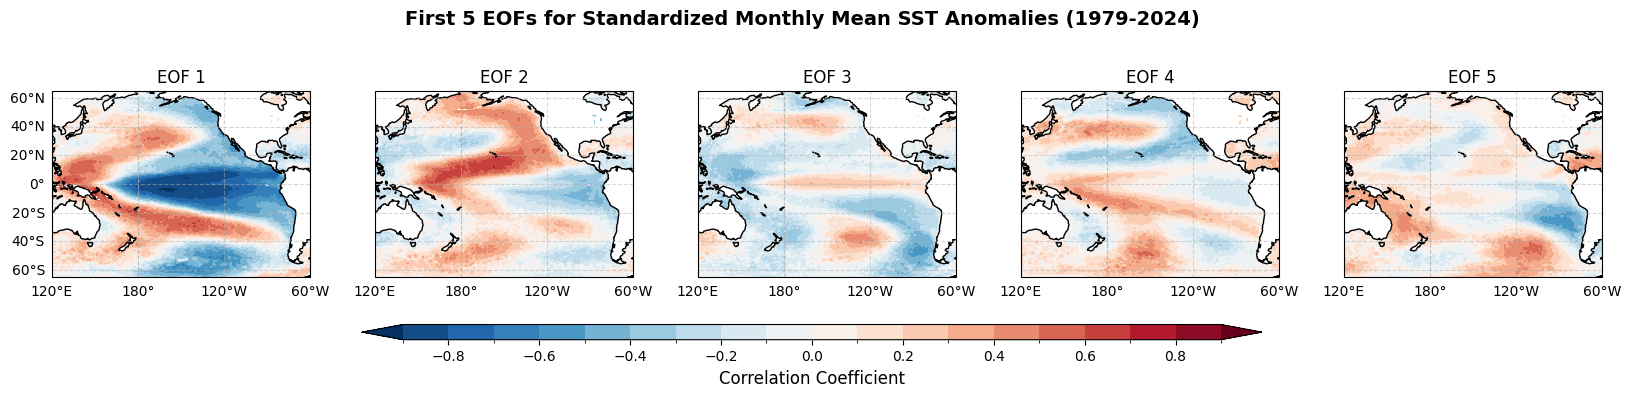

In [87]:
# Plot EOFs spatially
clevs = np.arange(-0.9,0.91,0.1)

fig, axes = plt.subplots(
    nrows=1, ncols=5, # 5 cols for 5 EOFs
    figsize=(20, 3.8),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)}
)

# Loop through each EOF
for i, ax in enumerate(axes):
    fill = eof1[i].plot.contourf(
        ax=ax,
        levels=clevs,
        cmap='RdBu_r',
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
        extend='both'
    )
    ax.add_feature(cfeature.COASTLINE, color='k')
    ax.set_title(f'EOF {i+1}', fontsize=12)

    # Add gridlines
    gl = ax.gridlines(alpha=0.5, linestyle='--', draw_labels=True)
    gl.bottom_labels = True
    if i == 0: 
        gl.left_labels = True,
    else: 
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False

# tighter vertical spacing
fig.subplots_adjust(top=0.82, bottom=0.20, wspace=0.25)

# Format figure and colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.45, 0.04])
cbar = fig.colorbar(fill, cax=cbar_ax,
                    orientation='horizontal', pad=0.08, shrink=0.5)
cbar.set_label('Correlation Coefficient', fontsize=12)
fig.suptitle('First 5 EOFs for Standardized Monthly Mean SST Anomalies (1979-2024)',
             fontsize=14, fontweight='bold', y=0.97)


plt.show()

## Part 4

(2.7523954456202225e-16, 0.19698093295097352)

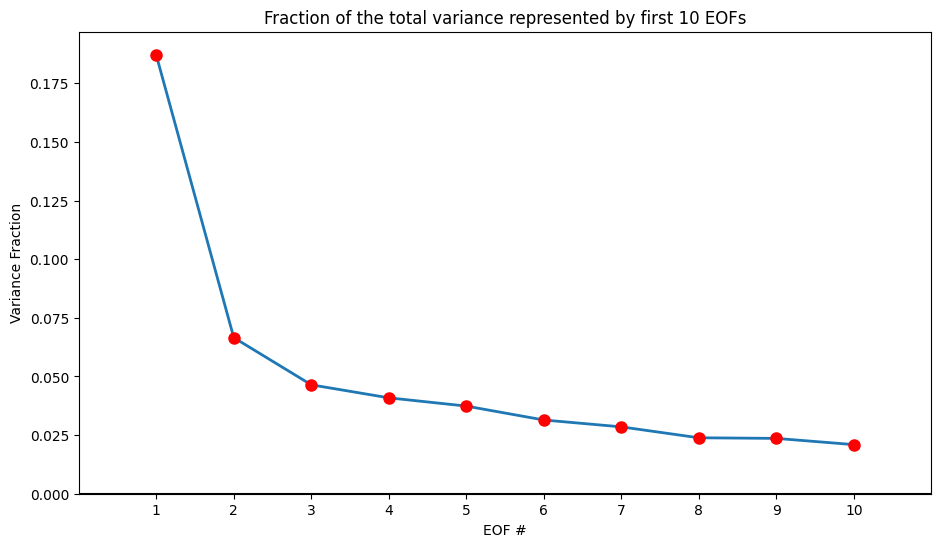

In [88]:
# Get fraction of variance for each EOF
varfrac = solver.varianceFraction()

# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None',
         marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by first 10 EOFs')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(0, 11)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

## Part 5

In [89]:
# Reconstruct SST anoms using first 5 EOFs
reconstruction = solver.reconstructedField(5)
reconstruction
# Also will be retrended and seasonalized

<xarray.DataArray 'sst_standardized' (time: 552, latitude: 521, longitude: 721)> Size: 829MB
array([[[            nan,             nan,             nan, ...,
          2.24242255e-01,  2.32688397e-01,  2.38500804e-01],
        [            nan,             nan,             nan, ...,
          2.41863728e-01,  2.42450491e-01,  2.42021665e-01],
        [            nan,             nan,             nan, ...,
          2.49236375e-01,  2.52666503e-01,  2.53628731e-01],
        ...,
        [ 2.59066038e-02,  2.18593013e-02,  1.77959669e-02, ...,
                     nan,             nan,             nan],
        [ 1.68246366e-02,  1.40482970e-02,  1.12957852e-02, ...,
                     nan,             nan,             nan],
        [ 1.15022026e-02,  1.00886980e-02,  1.00347800e-02, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          4.27801430e-01,  4.31046426e-01,  4.29643989e-01],
        [            nan,             nan,             nan, ...,
          4.31884408e-01,  4.22361553e-01,  4.12064880e-01],
        [            nan,             nan,             nan, ...,
          4.23674107e-01,  4.22465920e-01,  4.17112887e-01],
...
                     nan,             nan,             nan],
        [ 2.21618079e-02,  2.03527790e-02,  1.84312332e-02, ...,
                     nan,             nan,             nan],
        [-1.36311883e-02, -1.35510545e-02, -1.16459988e-02, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          1.51854157e-01,  1.73367113e-01,  1.92456678e-01],
        [            nan,             nan,             nan, ...,
          1.64242819e-01,  1.82823449e-01,  2.01426879e-01],
        [            nan,             nan,             nan, ...,
          1.92784071e-01,  2.17102289e-01,  2.39106357e-01],
        ...,
        [ 2.78330389e-02,  3.51921357e-02,  4.23471667e-02, ...,
                     nan,             nan,             nan],
        [-3.82248536e-02, -3.71173434e-02, -3.58475521e-02, ...,
                     nan,             nan,             nan],
        [-1.03006303e-01, -1.02113619e-01, -1.00967929e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    number     (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    expver     (time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001' '0001'
    month      (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  sst_standardized_reconstructed_with_5_EOFs

In [90]:
# Calculate correlation between reconstructed SST anoms
# and STT anom observations across the time series.
eof_corr = xr.corr(anom['sst'], reconstruction, dim='time')
eof_corr

<xarray.DataArray (latitude: 521, longitude: 721)> Size: 2MB
array([[       nan,        nan,        nan, ..., 0.1926809 , 0.19686909,
        0.19978723],
       [       nan,        nan,        nan, ..., 0.19215056, 0.19262896,
        0.19386254],
       [       nan,        nan,        nan, ..., 0.19397448, 0.2001207 ,
        0.20484726],
       ...,
       [0.14903921, 0.14433463, 0.13906445, ...,        nan,        nan,
               nan],
       [0.13007298, 0.12585725, 0.12113628, ...,        nan,        nan,
               nan],
       [0.09410219, 0.0909738 , 0.08734267, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0

/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


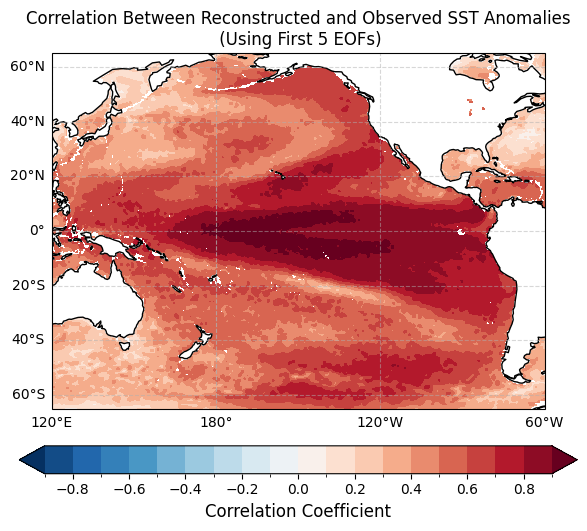

In [91]:
# Plot the leading EOF expressed as correlation in the Pacific domain.

clevs = np.arange(-0.9,0.91,0.1)

fig, ax = plt.subplots(1,1,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)}
)

fill = eof_corr.plot.contourf(
    ax=ax,
    levels=clevs,
    cmap='RdBu_r',
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    extend='both'
)
ax.add_feature(cfeature.COASTLINE, color='k')
ax.set_title(f'Correlation Between Reconstructed and ' 
             f'Observed SST Anomalies\n (Using First 5 EOFs)',
             fontsize=12)

# Add gridlines
gl = ax.gridlines(alpha=0.5, linestyle='--', draw_labels=True)
gl.bottom_labels = True
gl.left_labels = True,
gl.top_labels = False
gl.right_labels = False

cbar = fig.colorbar(fill, orientation='horizontal', pad=0.08, shrink=0.9)
cbar.set_label('Correlation Coefficient', fontsize=12)


## Part 6

In [92]:
anom

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number            (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * time              (time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude          (latitude) float64 4kB 65.0 64.75 64.5 ... -64.75 -65.0
  * longitude         (longitude) float64 6kB 120.0 120.2 120.5 ... 299.8 300.0
    expver            (time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
    month             (time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables:
    sst               (time, latitude, longitude) float32 829MB nan nan ... nan
    tcwv              (time, latitude, longitude) float32 829MB -0.5427 ... 0...
    sst_standardized  (time, latitude, longitude) float32 829MB nan nan ... nan

In [93]:
########### Standardize Total Column Water Vapor ###########
# Compute long term mean and std
mean = anom['tcwv'].mean(dim='time')
std = anom['tcwv'].std(dim='time')

# Avoid division by zero
std = std.where(std != 0)

# Standardize (subtract mean and divide by std)
tcwv_standardized = (anom['tcwv'] - mean) / std

# Check to see if std=1 and mean=0
print(tcwv_standardized.std().values)
print(tcwv_standardized.mean().values)

# Store variable back in anom
anom['tcwv_standardized'] = tcwv_standardized

0.7595147490501404
1.6648086784698535e-06


In [94]:

# Reconstruct SST anoms from first EOF
sst_eof1 = solver.reconstructedField(1)

# Calculate correlation between SST and TCWV
tcwv_eof_corr = xr.corr(anom['tcwv_standardized'], sst_eof1, dim='time')

/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


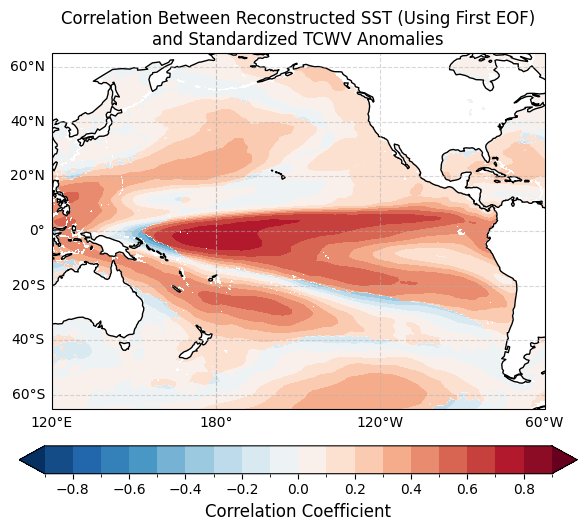

In [95]:
# Plot corr between first SST EOF and TCWV anoms
clevs = np.arange(-0.9,0.91,0.1)

fig, ax = plt.subplots(1,1,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)}
)

fill = tcwv_eof_corr.plot.contourf(
    ax=ax,
    levels=clevs,
    cmap='RdBu_r',
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    extend='both'
)
ax.add_feature(cfeature.COASTLINE, color='k')
ax.set_title(f'Correlation Between Reconstructed SST (Using First EOF)\n' 
             f'and Standardized TCWV Anomalies',
             fontsize=12)

gl = ax.gridlines(alpha=0.5, linestyle='--', draw_labels=True)
gl.bottom_labels = True
gl.left_labels = True,
gl.top_labels = False
gl.right_labels = False

cbar = fig.colorbar(fill, orientation='horizontal', pad=0.08, shrink=0.9)
cbar.set_label('Correlation Coefficient', fontsize=12)